In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import make_scorer

In [2]:
plays = pd.read_csv('Datas/lastfm/user_artists.dat', sep='\t') ## Dataset of relation between an artist 
## an user and the number listening 
artists = pd.read_csv('Datas/lastfm/artists.dat', sep='\t', usecols=['id','name','url']) ## id	name	url	pictureURL
#print(plays)
#print(artists)

# Merge artist and user pref data
ap = pd.merge(artists, plays, how="inner", left_on="id", right_on="artistID")
ap = ap.rename(columns={"weight": "playCount"})
#print('ap : \n', ap)

# Group artist by name
artist_rank = ap.groupby(['name']) \
    .agg({'userID' : 'count', 'playCount' : 'sum'}) \
    .rename(columns={"userID" : 'totalUsers', "playCount" : "totalPlays"}) \
    .sort_values(['totalPlays'], ascending=False)

artist_rank['avgPlays'] = artist_rank['totalPlays'] / artist_rank['totalUsers']
print('artist rank : \n', artist_rank)

artist rank : 
                     totalUsers  totalPlays     avgPlays
name                                                   
Britney Spears             522     2393140  4584.559387
Depeche Mode               282     1301308  4614.567376
Lady Gaga                  611     1291387  2113.563011
Christina Aguilera         407     1058405  2600.503686
Paramore                   399      963449  2414.659148
...                        ...         ...          ...
Morris                       1           1     1.000000
Eddie Kendricks              1           1     1.000000
Excess Pressure              1           1     1.000000
My Mine                      1           1     1.000000
A.M. Architect               1           1     1.000000

[17632 rows x 3 columns]


In [3]:
artists[artists['name']=='MALICE MIZER'].url.values[0]

'http://www.last.fm/music/MALICE+MIZER'

In [4]:
# Merge into ap matrix
ap = ap.join(artist_rank, on="name", how="inner") \
    .sort_values(['playCount'], ascending=False)
#print('ap : \n', ap)

# Preprocessing
pc = ap.playCount
play_count_scaled = (pc - pc.min()) / (pc.max() - pc.min())
#print(play_count_scaled)

ap = ap.assign(playCountScaled=play_count_scaled)
#print('ap : \n', ap)

# Build a user-artist rating matrix 
ratings_df = ap.pivot(index='userID', columns='artistID', values='playCountScaled')
ratings = ratings_df.fillna(0).values
#print('ratings : \n', ratings)

# Show sparsity
sparsity = float(len(ratings.nonzero()[0])) / (ratings.shape[0] * ratings.shape[1]) * 100
print("density: %.2f %%" % sparsity)

density: 0.28 %


In [5]:
from scipy.sparse import csr_matrix, csc_matrix, coo_matrix
'''selon le type de matrice sparse, la compresion n est pas la même'''

# Build a sparse matrix
X = csr_matrix(ratings)
#print(X)

n_users, n_items = ratings_df.shape
print("rating matrix shape", ratings_df.shape)

user_ids = ratings_df.index.values
artist_names = ap.sort_values("artistID")["name"].unique()


rating matrix shape (1892, 17632)


In [6]:
from lightfm import LightFM
from lightfm.evaluation import auc_score, precision_at_k, recall_at_k
from lightfm.cross_validation import random_train_test_split
from lightfm.data import Dataset

# Build data references + train test
Xcoo = X.tocoo()

# initialise le dataset du type (triplet)
data = Dataset()
data.fit(np.arange(n_users), np.arange(n_items))

interactions, weights = data.build_interactions(zip(Xcoo.row, Xcoo.col, Xcoo.data)) 
train, test = random_train_test_split(interactions)
train

<1892x17632 sparse matrix of type '<class 'numpy.int32'>'
	with 73758 stored elements in COOrdinate format>

In [7]:
# Train
model = LightFM(learning_rate=0.05, loss='warp')
model.fit(train, epochs=10, num_threads=2)

In [8]:
# Evaluate
train_precision = precision_at_k(model, train, k=10).mean()
test_precision = precision_at_k(model, test, k=10, train_interactions=train).mean()

train_auc = auc_score(model, train).mean()
test_auc = auc_score(model, test, train_interactions=train).mean()

print('Precision: train %.2f, test %.2f.' % (train_precision, test_precision))
print('AUC: train %.2f, test %.2f.' % (train_auc, test_auc))

Precision: train 0.37, test 0.13.
AUC: train 0.96, test 0.86.


In [9]:
# Predict
scores = model.predict(0, np.arange(n_items))
top_items = artist_names[np.argsort(-scores)]
print(top_items)

['The Beatles' 'Depeche Mode' 'Arctic Monkeys' ... 'The Faceless'
 'The Contortionist' 'After the Burial']


## Part 1 : Fonction de recommandation
On va entreiner le modèle avec fonction loss = 'warp'

In [10]:
model = LightFM(learning_rate=0.05, loss='warp')
model.fit(train, epochs=10, num_threads=2)

In [11]:
def get_recommandation(user, model=model, n_reco=10, print_ok=False):
    
    liste_user_idx = list(user_ids)
    idx = liste_user_idx.index(userID)
    scores = model.predict(idx, np.arange(n_items))
    top_items_pred = artist_names[np.argsort(-scores)]
    if print_ok:
        print(f'Liste des {n_reco} artistes recommandés :', top_items_pred[:n_reco])
    return top_items

In [12]:
def get_ground_truth(user, n_reco=10, print_ok=False):
    
    liste_user_idx = list(user_ids)
    idx = liste_user_idx.index(userID)
    top_items_true = ap[ap['userID']==idx] \
                    .sort_values(['playCountScaled'], ascending=False) \
                    .name[:10]
    if print_ok:
        print(f'Liste des {n_reco} artistes réellement écoutés :', top_items_true[:n_reco])
    return top_items

In [13]:
userID = 34
liste_user_idx = list(user_ids)
idx = liste_user_idx.index(userID)
print(idx)

top_artists_predicted = get_recommandation(userID, print_ok=True)
top_artists_true = get_ground_truth(userID, print_ok=True)

31
Liste des 10 artistes recommandés : ['Radiohead' 'The Beatles' 'Depeche Mode' 'Sigur Rós' 'Pink Floyd'
 'Placebo' 'Nine Inch Nails' 'Muse' 'U2' 'The Cure']
Liste des 10 artistes réellement écoutés : 2579       Depeche Mode
41304     Pet Shop Boys
42674    Bonanza Banzai
42675            Recoil
42707          Ladytron
40578          t.A.T.u.
37813        Nitzer Ebb
42763              Fake
42764        Hubert Kah
13184    Britney Spears
Name: name, dtype: object


## Part 2

### Choix de la meilleur fonction de coût

In [14]:
import time
from collections import defaultdict

loss_val = ['logistic', 'bpr', 'warp', 'warp-kos']

def append_res_list(res, name, time, prec, recall, AUC):
    res[name].append([
                time,
                prec,  
                recall,           
                AUC,           
            ])
    return res

train_res = defaultdict(list)
test_res = defaultdict(list)
for loss in loss_val:
    name = 'loss-'+loss
    
    model = LightFM(learning_rate=0.05, loss=loss)
    t0 = time.time()
    model.fit(train, epochs=10, num_threads=2)
    fit_time = time.time() - t0
    
    ## precision
    train_precision = precision_at_k(model, train, k=10).mean()
    test_precision = precision_at_k(model, test, k=10, train_interactions=train).mean()
    
    ## recal
    train_recall = recall_at_k(model, train, k=10).mean()
    test_recall = recall_at_k(model, test, k=10, train_interactions=train).mean()
    
    ## AUC
    train_auc = auc_score(model, train).mean()
    test_auc = auc_score(model, test, train_interactions=train).mean()
    
    ## resultats summury
    
    train_res = append_res_list(train_res, name, fit_time, 
                         train_precision, train_recall, train_auc)
    

    test_res = append_res_list(test_res, name, fit_time, 
                         test_precision, test_recall, test_auc)

In [15]:
def print_df_resultats(res):
    # Compute mean and std
    final = {}
    for model in res:
        arr = np.array(res[model])
        final[model] = {
            "time (s)" : arr[:,0].mean().round(3),
            "precision " : arr[:,1].mean().round(3),
            "recall" : arr[:,2].mean().round(3),
            "AUC" : arr[:,3].mean().round(3),
        }

    df = pd.DataFrame.from_dict(final, orient="index").round(3)
    return df

In [16]:
print("Results obtained on train set")
df_train = print_df_resultats(train_res)
df_train

Results obtained on train set


,time (s),precision,recall,AUC
loss-logistic,0.315,0.200,0.052,0.887
loss-bpr,0.473,0.372,0.096,0.848
loss-warp,0.525,0.392,0.101,0.967
loss-warp-kos,0.990,0.356,0.092,0.889


In [17]:
print("Results obtained on test set")
df_test = print_df_resultats(test_res)
df_test

Results obtained on test set


,time (s),precision,recall,AUC
loss-logistic,0.315,0.068,0.070,0.811
loss-bpr,0.473,0.120,0.124,0.773
loss-warp,0.525,0.137,0.141,0.861
loss-warp-kos,0.990,0.126,0.128,0.824


Le meilleur modèle terme de précision, recall et AUC est lorsque l'on choisi la fonction loss = 'wrap'. C'est vrai pour le training et le testing set.

### Etude de la convergence

In [18]:
learn_rate = 0.05
nb_epochs = 30
model1 = LightFM(learning_rate=learn_rate, loss='warp', random_state = 42)

def append_res(res, name, time, epochs, AUC):
    res[name].append([
                time,
                epochs,           
                AUC,           
            ])
    return res

def AUC_fcn_of_epochs(model, train, nb_epochs):
    train_res = defaultdict(list)
    for i in range(nb_epochs):
        name = 'ligthFM-loss_wrap'
        t0 = time.time()  
        model.fit_partial(train, epochs=1, num_threads=2)
        fit_time = time.time() - t0

        ## AUC
        train_auc = auc_score(model, train).mean()
        test_auc = auc_score(model, test, train_interactions=train).mean()

        ## resultats summury

        train_res = append_res(train_res, name, fit_time, 
                             i, train_auc)
    return train_res

In [19]:
train_res = AUC_fcn_of_epochs(model1, train, nb_epochs)

In [20]:
arr = np.array(train_res['ligthFM-loss_wrap'])
df = pd.DataFrame(arr, columns=['time_s', 'i', 'AUC'])
#df.head(7)

A partir d'un epochs = 18, l'AUC est suppérieur à 0.98 (valeur : 0.98).
Le temps d'apprentissage est de 1.314 secondes
Attention cette courbe dépend du learning rate choisi.


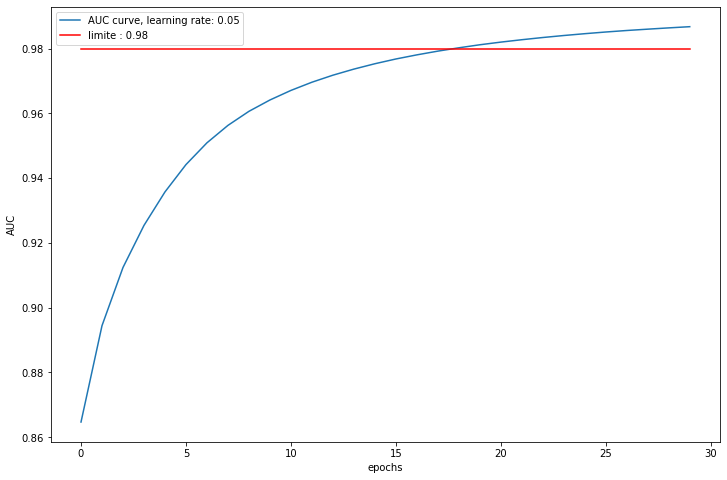

In [21]:
AUC_lim = 0.98

def plot_AUC_fcn_of_epochs(df, AUC_lim, learn_rate):
    for idx in df.index:
        if df.AUC[idx]>=AUC_lim:
            break

    plt.figure(figsize=(12,8))
    plt.plot(df[['i']].values, df[['AUC']].values, label=f'AUC curve, learning rate: {learn_rate}')
    plt.plot(df.i.values, AUC_lim*np.ones(len(df.i)), 'r', label=f'limite : {AUC_lim}')
    plt.xlabel('epochs')
    plt.ylabel('AUC')
    plt.legend()


    print(f"A partir d'un epochs = {int(df.i[idx])}, l'AUC est suppérieur à {AUC_lim} (valeur : {df.AUC[idx].round(3)}).")
    print(f"Le temps d'apprentissage est de {df.time_s[:idx].sum().round(3)} secondes")
    
plot_AUC_fcn_of_epochs(df, AUC_lim, learn_rate)
print('Attention cette courbe dépend du learning rate choisi.')

A partir d'un epochs = 49, l'AUC est suppérieur à 0.98 (valeur : 0.929).
Le temps d'apprentissage est de 4.098 secondes


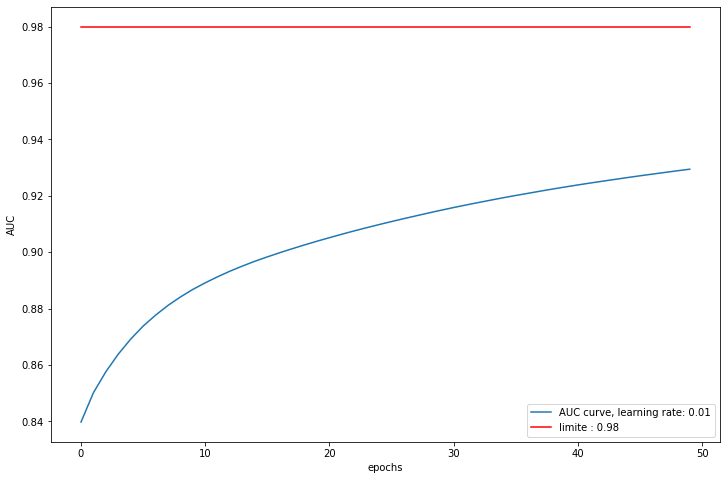

In [22]:
learn_rate = 0.01
nb_epochs = 50
model1 = LightFM(learning_rate=learn_rate, loss='warp', random_state = 42)
train_res = AUC_fcn_of_epochs(model1, train, nb_epochs)

arr = np.array(train_res['ligthFM-loss_wrap'])
df = pd.DataFrame(arr, columns=['time_s', 'i', 'AUC'])

plot_AUC_fcn_of_epochs(df, AUC_lim, learn_rate)

Ici, le learning rate est trop bas, l'algorithme n'as pas le temps d'apprendre suffisament rapidement pour obtenir l'AUC désiré.

### Test d'optimisation d'hyper-paramètres avec GreadSearchCV

Le module GreadSearchCV de sklearn n'compatible avec les modèles lightfm (due à la forme des matrices pour le train et le test set, ici on applique un masque sur la matrice X alors que dans sklearn seleument certaines lignes sont sélectionnées).

Mais le jeu en valant la chandèle pour pouvoir optimiser tous les paramètre avec une grille de recherche, nous allons implémenter notre fonction de GridSearch.

In [23]:
## affichage des paramètre 
LightFM().get_params().keys()

dict_keys(['loss', 'learning_schedule', 'no_components', 'learning_rate', 'k', 'n', 'rho', 'epsilon', 'max_sampled', 'item_alpha', 'user_alpha', 'random_state'])

In [24]:
AUC_scorer = make_scorer(auc_score)

grid_params = {
    'loss' : ['bpr', 'warp', 'warp-kos'], # 'logistic', 
    'no_components' : [1, 5, 10, 20],
    'learning_rate' : [0.5, 1e-2, 5e-2],
    'k' : [1, 5, 10, 20],
} 

list_combin_params = list(ParameterGrid(grid_params))


In [39]:
def my_GridSearch(list_combin_params):
    train_res = defaultdict(list)
    test_res = defaultdict(list)
    i=0
    for params in list_combin_params:
        name = i
        
        model = LightFM(**params)
        
        t0 = time.time()
        model.fit(train, epochs=15, num_threads=2)
        fit_time = time.time() - t0

        ## precision
        train_precision = precision_at_k(model, train, k=10).mean()
        test_precision = precision_at_k(model, test, k=10, train_interactions=train).mean()

        ## recal
        train_recall = recall_at_k(model, train, k=10).mean()
        test_recall = recall_at_k(model, test, k=10, train_interactions=train).mean()

        ## AUC
        train_auc = auc_score(model, train).mean()
        test_auc = auc_score(model, test, train_interactions=train).mean()

        ## resultats summury

        train_res = append_res_list(train_res, name, fit_time, 
                             train_precision, train_recall, train_auc)


        test_res = append_res_list(test_res, name, fit_time, 
                             test_precision, test_recall, test_auc)
        i+=1
    return train_res, test_res

In [26]:
from joblib import Parallel, delayed
import multiprocessing

num_cores = multiprocessing.cpu_count()

train_res, test_res = my_GridSearch(list_combin_params)
# train_res, test_res = Parallel(n_jobs=num_cores)(delayed(my_GridSearch)(i) for i in list_combin_params)

dict_items([('k', 1), ('learning_rate', 0.5), ('loss', 'bpr'), ('no_components', 1)])
dict_items([('k', 1), ('learning_rate', 0.5), ('loss', 'bpr'), ('no_components', 5)])
dict_items([('k', 1), ('learning_rate', 0.5), ('loss', 'bpr'), ('no_components', 10)])
dict_items([('k', 1), ('learning_rate', 0.5), ('loss', 'bpr'), ('no_components', 20)])
dict_items([('k', 1), ('learning_rate', 0.5), ('loss', 'warp'), ('no_components', 1)])
dict_items([('k', 1), ('learning_rate', 0.5), ('loss', 'warp'), ('no_components', 5)])
dict_items([('k', 1), ('learning_rate', 0.5), ('loss', 'warp'), ('no_components', 10)])
dict_items([('k', 1), ('learning_rate', 0.5), ('loss', 'warp'), ('no_components', 20)])
dict_items([('k', 1), ('learning_rate', 0.5), ('loss', 'warp-kos'), ('no_components', 1)])
dict_items([('k', 1), ('learning_rate', 0.5), ('loss', 'warp-kos'), ('no_components', 5)])
dict_items([('k', 1), ('learning_rate', 0.5), ('loss', 'warp-kos'), ('no_components', 10)])
dict_items([('k', 1), ('learni

dict_items([('k', 10), ('learning_rate', 0.01), ('loss', 'warp-kos'), ('no_components', 1)])
dict_items([('k', 10), ('learning_rate', 0.01), ('loss', 'warp-kos'), ('no_components', 5)])
dict_items([('k', 10), ('learning_rate', 0.01), ('loss', 'warp-kos'), ('no_components', 10)])
dict_items([('k', 10), ('learning_rate', 0.01), ('loss', 'warp-kos'), ('no_components', 20)])
dict_items([('k', 10), ('learning_rate', 0.05), ('loss', 'bpr'), ('no_components', 1)])
dict_items([('k', 10), ('learning_rate', 0.05), ('loss', 'bpr'), ('no_components', 5)])
dict_items([('k', 10), ('learning_rate', 0.05), ('loss', 'bpr'), ('no_components', 10)])
dict_items([('k', 10), ('learning_rate', 0.05), ('loss', 'bpr'), ('no_components', 20)])
dict_items([('k', 10), ('learning_rate', 0.05), ('loss', 'warp'), ('no_components', 1)])
dict_items([('k', 10), ('learning_rate', 0.05), ('loss', 'warp'), ('no_components', 5)])
dict_items([('k', 10), ('learning_rate', 0.05), ('loss', 'warp'), ('no_components', 10)])
dict

In [27]:
print("Results obtained on train set")
df_train = print_df_resultats(train_res)
df_train.head()

Results obtained on train set


,time (s),precision,recall,AUC
0,0.722,0.027,0.007,0.793
1,0.950,0.121,0.032,0.944
2,1.243,0.240,0.063,0.972
3,1.264,0.431,0.114,0.986
4,0.612,0.013,0.003,0.634


In [28]:
max_index = np.argmax(df_train.AUC)
print('maximum value for AUC :',df_train.AUC[max_index])

best_params = ParameterGrid(grid_params)[max_index].items()
print(f"Les meilleurs paramètres pour le modèle sont {best_params}")

maximum value for AUC : 0.994
Les meilleurs paramètres pour le modèle sont dict_items([('no_components', 20), ('loss', 'warp-kos'), ('learning_rate', 0.05), ('k', 20)])


A partir d'un epochs = 5, l'AUC est suppérieur à 0.98 (valeur : 0.983).
Le temps d'apprentissage est de 0.877 secondes


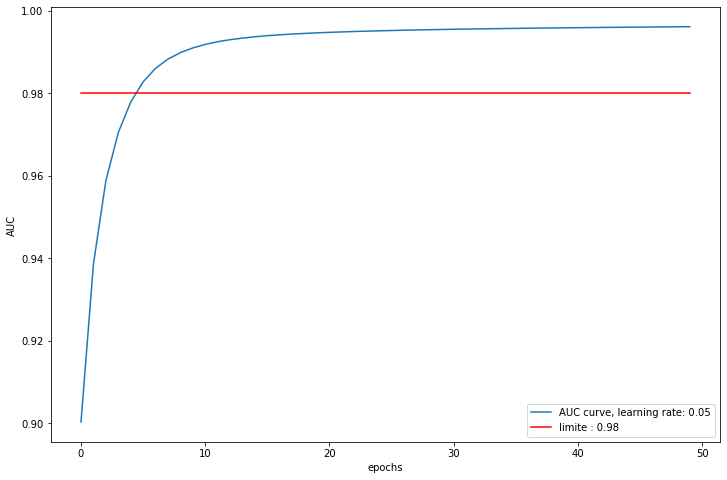

In [29]:
learn_rate = 0.05
nb_epochs = 50
model1 = LightFM(learning_rate=learn_rate, k=10, loss='warp-kos', 
                 random_state = 42, no_components=20)
train_res = AUC_fcn_of_epochs(model1, train, nb_epochs)

arr = np.array(train_res['ligthFM-loss_wrap'])
df = pd.DataFrame(arr, columns=['time_s', 'i', 'AUC'])

plot_AUC_fcn_of_epochs(df, AUC_lim, learn_rate)

### Part 3 : App client-Server
#### Vectorisation utilisateur

In [30]:
select0 = ['MALICE MIZER', 'Diary of Dreams', 'Carpathian Forest', 'Depeche Mode']
select1 = ['MALICE MIZER', 'Diary of Dreams', 'Carpathian Forest', 
           'Coptic Rain', 'Oz Alchemist', 'Grzegorz Tomczak']

In [31]:
def add_new_user(ratings_df, select, artist_names, ap):
    user_ids = ratings_df.index.values
    new_user = max(user_ids)+1
    new_user_artist = np.zeros(len(artist_names))
    i=0
    for artist in artist_names:
        if artist in select:
            new_user_artist[i] = ap.playCountScaled[ap['name']==artist].mean()
        i +=1  
    ratings_df.loc[new_user] = new_user_artist
    return ratings_df

In [32]:
ratings_df = add_new_user(ratings_df, select0, artist_names, ap)
user_ids = ratings_df.index.values

In [33]:
ratings_df = add_new_user(ratings_df, select1, artist_names, ap)
user_ids = ratings_df.index.values

In [34]:
ratings = ratings_df.fillna(0).values
ratings

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.00115397, ..., 0.        , 0.        ,
        0.        ],
       [0.00072584, 0.0018902 , 0.00072962, ..., 0.        , 0.        ,
        0.        ],
       [0.00072584, 0.0018902 , 0.00072962, ..., 0.00081089, 0.00080806,
        0.001205  ]])

### Utilisation de minisearch
#### Create Json artists

In [35]:
artists

,id,name,url
0,1,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER
1,2,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams
2,3,Carpathian Forest,http://www.last.fm/music/Carpathian+Forest
3,4,Moi dix Mois,http://www.last.fm/music/Moi+dix+Mois
4,5,Bella Morte,http://www.last.fm/music/Bella+Morte
...,...,...,...
17627,18741,Diamanda Galás,http://www.last.fm/music/Diamanda+Gal%C3%A1s
17628,18742,Aya RL,http://www.last.fm/music/Aya+RL
17629,18743,Coptic Rain,http://www.last.fm/music/Coptic+Rain
17630,18744,Oz Alchemist,http://www.last.fm/music/Oz+Alchemist


In [36]:
artists.shape[0]

17632

In [37]:
artists_json = [{'id': str(artists.id[i]), 'name': artists.name[i]} for i in range(artists.shape[0])]

In [41]:
import json
artists_doc = json.dumps(artists_json)
